# CycleGAN training Notebook




This notebook starts the training of our re-implementation of the CycleGAN by Zhu et al. Firstly, the datasets are loaded and preprocessed. Then, the network is initialized and training is started.

In [ ]:
!pip install -U tensorflow-addons

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import os
import sys

import time
import datetime 

import matplotlib.pyplot as plt

## Importing modules from git repository

In the following the git repository will be cloned for the current runtime. Alternatively the following lines can be uncommented to mount your google drive and clone the repository permanently.

In [ ]:
#from google.colab import drive
#drive.mount("/content/drive")


Either execute the following cell, or to clone the git repository permanently navigate to the desired destination in google drive in the following line. If you clone the repository to your google drive, this cell needs to be executed only once.

In [ ]:
#% cd "insert path here"
!git clone "https://github.com/ktargan/project-cycleGAN.git"

If you cloned the repository to your drive, make sure that you are working on the state of the repository that is most up-to-date by using git pull.

In [ ]:
#navigate to git repository (change path if in drive)
% cd /content/project-cycleGAN/
! git pull

Now we can import the required files from the repository, make sure to insert the correct path.

In [ ]:
sys.path.insert(0,"/content/project-cycleGAN/")

import losses
import generator
import discriminator
import train_step
import load_dataset
from utils import buffer
from utils import img_ops

## Dataset
In the cells below you can load two datasets. As a default we work with the horse2zebra dataset, however, custom small datasets stored in google drive can also be loaded via the function get_custom(), if you insert the right path. 

In [ ]:
horse_dataset, zebra_dataset, test_horses, test_zebras = load_dataset.get_horses(batchsize=1)

Load dataset with planets from google drive, will be referenced as fantasy dataset.

In [ ]:
#For custom fantasy datasets (! should have no more than about 25 images) 
#uncomment the following lines and insert the correct path
#you can either load two custom small datasets or combine one with the orange dataset as we did for our planets:

#fantasy_dataset = load_dataset.get_custom("INSERT_PATH", batchsize=1)
#orange_dataset, test_oranges = load_dataset.get_oranges(1)

#too run the code in this following cells, store the datasets in the variables train_horses and zebras:
#zebra_dataset = fantasy_dataset
#horse_dataset = orange_dataset

## Timing

In [ ]:
# used later on to compute duration of an epoch
def timing(start):
    now = time.time()
    time_per_training_step = now - start
    
    return round(time_per_training_step, 2)

##Start the Training

First generators and discriminators are initialized. For longer training, we did store checkpoints frequently to make sure that we do not loose training progress (due to runtime disconnection etc.). The code for this is still included as comments. 
We use Tensorboard to track the training progress. Keep in mind that it might not work in Colab if you deactivated third party cookies or use a script blocker.

In [ ]:
%load_ext tensorboard

#Preparartions to use tensorboard
!rm -rf ./logs/gradient_tape
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'

train_summary_writer = tf.summary.create_file_writer(train_log_dir)

# We will train 2 generators and 2 discriminators
# generator_horses learns to translate zebra to horse images - i.e. generates horse images
generator_horses = generator.Generator()
# generator_zebras learns to translate horse to zebra images
generator_zebras = generator.Generator()

#discriminator horses learns to distinguish between true horse images and generated ones
# receptive field on the patchGAN is set to 70, to create 70x70 image patches
discrim_horses = discriminator.Discriminator(70)
# the other way round
discrim_zebras = discriminator.Discriminator(70)

#Zhu et al. use a learning rate of 0.0002 for the first 100 epochs and then start decreasing it
#They keep the same learning rate for the first 100 epochs and linearly decay the rate to 
#zero over the next 100 epochs.
#however due to computational reasons we only train for 100 epochs and thus keep 
#the learning rate stable
learning_rate = 0.0002

#Zhu et al. use a lambda factor for weighting the cycle consistency loss and the identity loss
#The identity loss is weighted by 0.5*lambda the cycle consitency loss by 1*lambda 
lambda_factor = 10

#Insert the desired training epoch number here
num_epochs = 30

#optimizers for all models
gen_horse_optimizer = tf.keras.optimizers.Adam(learning_rate)
gen_zebra_optimizer = tf.keras.optimizers.Adam(learning_rate)
disc_horse_optimizer = tf.keras.optimizers.Adam(learning_rate)
disc_zebra_optimizer = tf.keras.optimizers.Adam(learning_rate)

#create a folder to store checkpoints (here we store it in google drive to make sure 
#that all progress is saved permantently)

#checkpoint_path = "INSERT_PATH"
#if not os.path.exists(checkpoint_path):
#    os.makedirs(checkpoint_path)
#
##create checkpoint manager and store model and optimizer state in case "save" is called
#ckpt = tf.train.Checkpoint(generator_horses=generator_horses,
#                           generator_zebras =generator_zebras,
#                           discrim_horses=discrim_horses,
#                           discrim_zebras=discrim_zebras,
#                           gen_horse_optimizer=gen_horse_optimizer,
#                           gen_zebra_optimizer=gen_zebra_optimizer,
#                           disc_horse_optimizer=disc_horse_optimizer,
#                           disc_zebra_optimizer=disc_zebra_optimizer)
#ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10)
#
##if a checkpoint exists, restore the latest checkpoint.
#if ckpt_manager.latest_checkpoint:
#  ckpt.restore(ckpt_manager.latest_checkpoint)
#  print ('Latest checkpoint restored!')

#initialize lists to save model losses in
discrim_horse_losses = []
discrim_zebra_losses = []
gen_horse_losses = []
gen_zebra_losses = []


#start the training
for epoch in range(num_epochs):
  print("epoch: ", epoch+1, " ----------------------------------------------------------")

  #create empty buffers to store generated images in (so that discriminator can use these in the training step)
  #buffer is filled via the image_buffer function in the training steps
  buffer_horse = buffer.Buffer(50)
  buffer_zebra = buffer.Buffer(50)
  
  #fill buffers with random images
  generated_img = tf.random.normal([50,128,128,3])
  buffer_horse.set_image_buffer(generated_img)
  buffer_zebra.set_image_buffer(generated_img)

  start = time.time()

  #create variables to save averaged losses
  running_gen_zebra_loss = 0
  running_gen_horse_loss = 0
  running_disc_zebra_loss = 0
  running_disc_horse_loss = 0
  running_average_factor = 0.95

  #iterate through the datasets and train the models
  for horse_img, zebra_img in tf.data.Dataset.zip((horse_dataset, zebra_dataset)):
    #take generated/random images from buffer
    gen_img_horsebuffer = buffer_horse.get_image_buffer()
    gen_img_zebrabuffer = buffer_zebra.get_image_buffer()  

    #calculate the losses for generators and discriminators:

    #first, training step for the discriminators: check performance on real images and generated ones
    disc_loss_zebra = train_step.training_step_discrim(discrim_zebras, disc_zebra_optimizer, zebra_img, gen_img_zebrabuffer)
    disc_loss_horse = train_step.training_step_discrim(discrim_horses, disc_horse_optimizer, horse_img, gen_img_horsebuffer)
    
    #train the generators 
    gen_loss_zebra, gen_loss_horse, fake_images_zebra, fake_images_horse = train_step.training_step_gen(generator_zebras, generator_horses, 
                                          discrim_zebras, discrim_horses, zebra_img, 
                                          horse_img, gen_zebra_optimizer, gen_horse_optimizer, lambda_factor)

    #also save generated images in the respective buffers
    buffer_zebra.set_image_buffer(fake_images_zebra)
    buffer_horse.set_image_buffer(fake_images_horse)

    #loss updates
    running_gen_zebra_loss = running_average_factor* running_gen_zebra_loss + (1- running_average_factor)*gen_loss_zebra
    running_gen_horse_loss = running_average_factor* running_gen_horse_loss + (1- running_average_factor)*gen_loss_horse

    running_disc_zebra_loss = running_average_factor* running_disc_zebra_loss + (1- running_average_factor)*disc_loss_zebra
    running_disc_horse_loss = running_average_factor* running_disc_horse_loss + (1- running_average_factor)*disc_loss_horse

  #save losses in respective list
  discrim_zebra_losses.append(running_disc_zebra_loss)
  discrim_horse_losses.append(running_disc_horse_loss)

  gen_zebra_losses.append(running_gen_zebra_loss)
  gen_horse_losses.append(running_gen_horse_loss)

  #print statements to check on current training state
  print(f"the training step and test evaluation took {timing(start)} seconds")

  ##every 5th epoch save a checkpoint
  #if (epoch + 1) % 5 == 0:
  #  ckpt_save_path = ckpt_manager.save()
  #  print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  # Generate an image of a 2x2 gridplot with sample images for both datasets 
  # and corresponding translated images generated by our network 
  image = img_ops.plot_to_tf_image(generator_zebras, generator_horses, zebra_dataset, horse_dataset)

  # Add the losses  of the model and the sample images to tensorboard
  with train_summary_writer.as_default():
    tf.summary.scalar('generator_horse loss', running_gen_horse_loss,  step= epoch+1)
    tf.summary.scalar('generator_zebra loss', running_gen_zebra_loss,  step= epoch+1)
    tf.summary.scalar('discriminator_horse loss', running_disc_horse_loss,  step= epoch+1)
    tf.summary.scalar('discriminator_zebra loss', running_disc_zebra_loss,  step= epoch+1)
    tf.summary.image('sample images', image,  step= epoch+1)
    
  # Load the tensorboard once and update it manually inside the tensorboard interface
  if epoch == 0:
    %tensorboard --logdir logs/gradient_tape


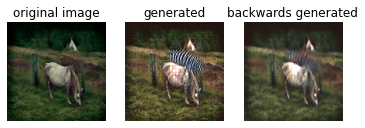

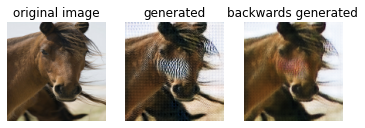

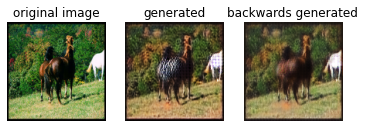

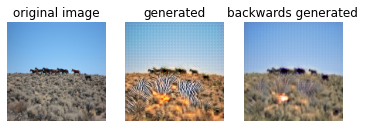

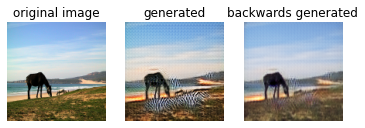

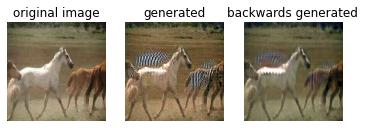

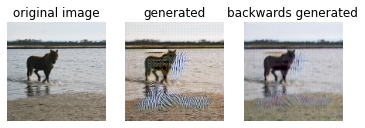

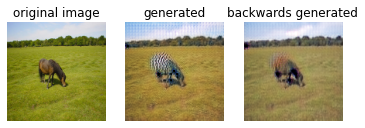

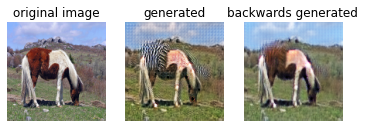

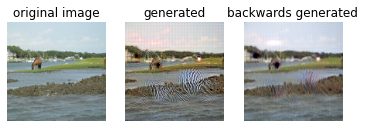

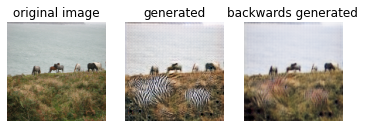

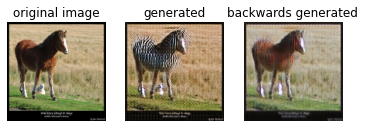

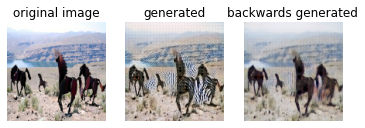

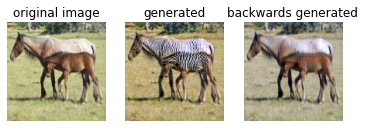

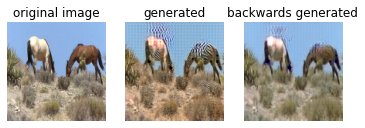

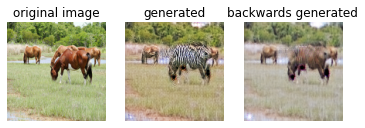

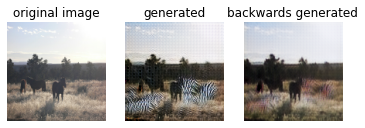

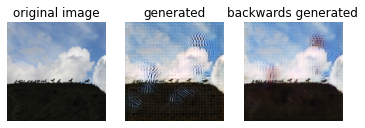

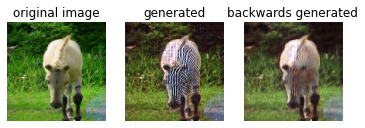

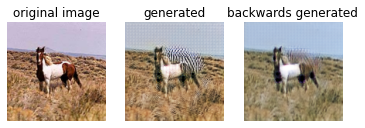

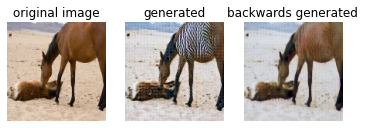

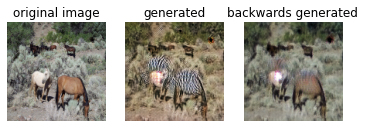

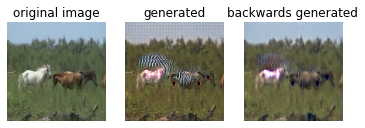

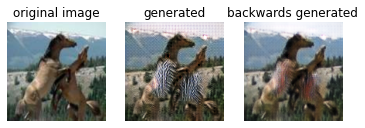

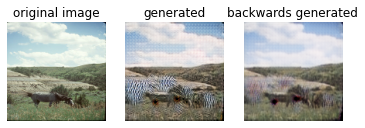

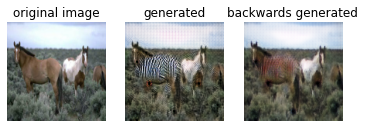

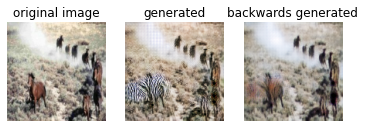

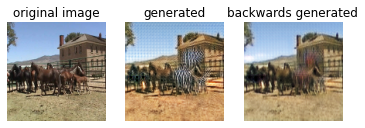

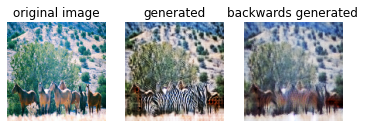

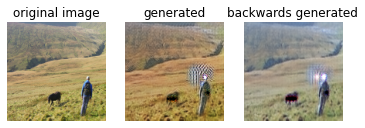

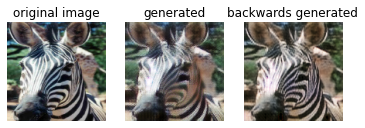

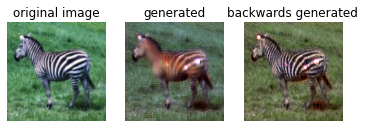

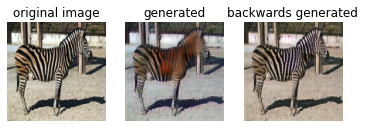

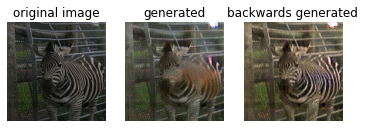

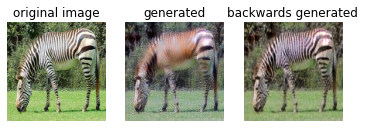

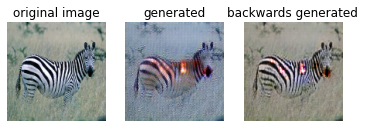

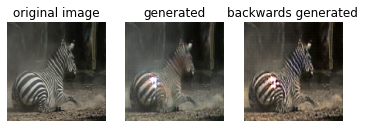

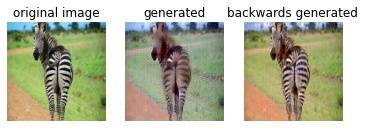

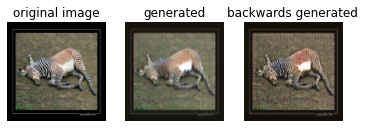

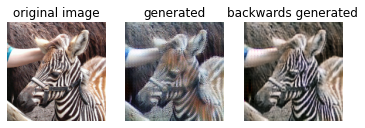

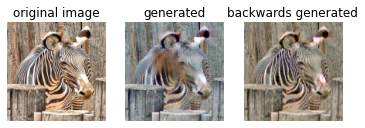

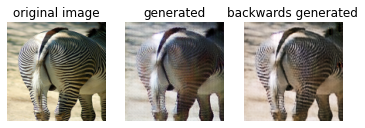

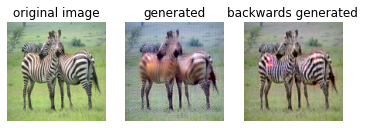

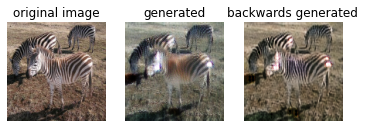

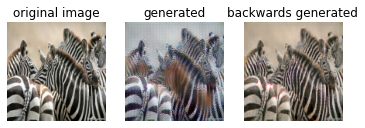

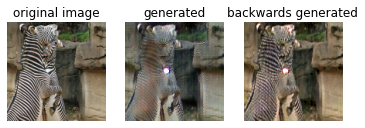

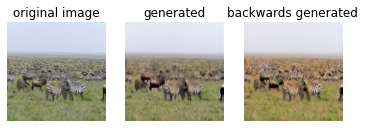

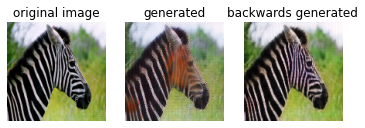

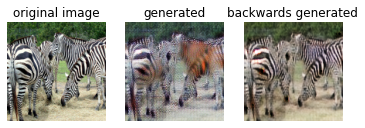

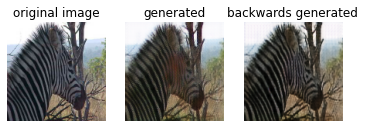

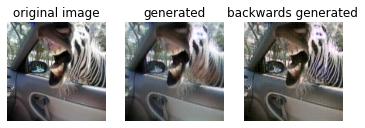

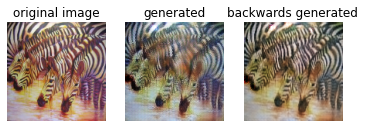

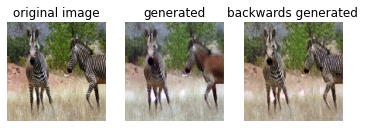

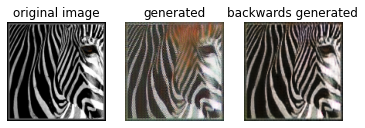

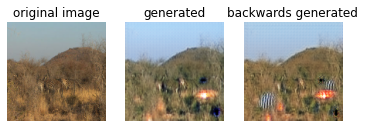

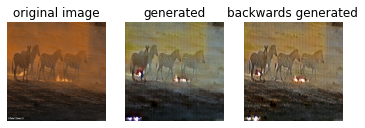

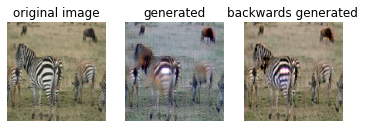

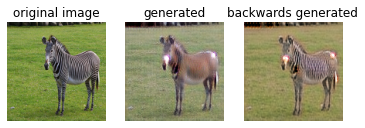

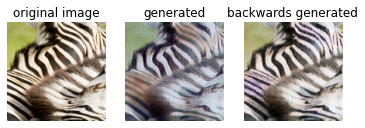

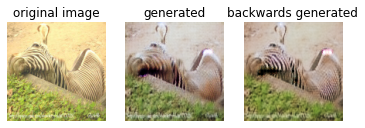

In [ ]:
#prints the first 30 pictures (to have comparable output for ablations studies)
img_ops.plot_image_cycle(generator_zebras,generator_horses, test_zebras, test_horses, ablation = True)